Ce notebook combine les niveaux 2, 3 et 4, mais cela n'a pas de sens, on ne peut combiner que les niveaux 3 et 4 et pas le niveau 2 avec eux.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from d2l import torch as d2l
import time
from sklearn.metrics import f1_score
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
path = "F:/Document/France/ENPC/Cours/S5/Projet/data/"
os.chdir(path)
df_data = pd.read_csv("alldata.csv", header=0)
df_data = df_data.dropna()
df_data = df_data.drop(df_data[df_data['Exploitable'] == 0].index)

In [3]:
list_vitesse = []
for i in df_data['Vitesse']:
    list_vitesse.append(eval(i))

list_frf_reel = []
for i in df_data['FRF réel']:
    list_frf_reel.append(eval(i))

list_frf_imag = []
for i in df_data['FRF imag']:
    list_frf_imag.append(eval(i))

np_vitesse = np.array(list_vitesse)
np_frf_reel = np.array(list_frf_reel)
np_frf_imag = np.array(list_frf_imag)
np_frf = np.sqrt(np.square(np_frf_reel) + np.square(np_frf_imag))

np_classe = df_data['Niveau'].values

In [4]:
np_classe_3 = np.where(np_classe < 2, np_classe, 2)
name_class, count_class = np.unique(np_classe_3, return_counts=True)
name_class, count_class

(array([0., 1., 2.]), array([ 7945, 10241,  2418], dtype=int64))

In [5]:
np_classe_3 = pd.get_dummies(np_classe_3).values

np_data = np.concatenate((np_vitesse, np_frf, np_classe_3), axis=1)
np.random.shuffle(np_data)

np_vitesse_new = np_data[:, :614]
np_frf_new = np_data[:, 614:1228]
np_classe_new = np_data[:, 1228:]
np_feature = np.concatenate((np_vitesse_new, np_frf_new), axis=1)

In [6]:
threshold1 = int(0.6*np_feature.shape[0])
threshold2 = int(0.8*np_feature.shape[0])
np_X_train = np_feature[:threshold1]
np_Y_train = np_classe_new[:threshold1]
np_X_valid = np_feature[threshold1:threshold2]
np_Y_valid = np_classe_new[threshold1:threshold2]
np_X_test = np_feature[threshold2:]
np_Y_test = np_classe_new[threshold2:]

In [7]:
X_train = torch.tensor(np_X_train, dtype=torch.float32).reshape(np_X_train.shape[0], 2, np_X_train.shape[1] // 2)
Y_train = torch.tensor(np_Y_train, dtype=torch.float32)
X_valid = torch.tensor(np_X_valid, dtype=torch.float32).reshape(np_X_valid.shape[0], 2, np_X_valid.shape[1] // 2)
Y_valid = torch.tensor(np_Y_valid, dtype=torch.float32)
X_test = torch.tensor(np_X_test, dtype=torch.float32).reshape(np_X_test.shape[0], 2, np_X_test.shape[1] // 2)
Y_test = torch.tensor(np_Y_test, dtype=torch.float32)

In [8]:
class Residual1d(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))  # conv1 +batchnorm + relu
        Y = self.bn2(self.conv2(Y))  # conv2 + batchnorm
        if self.conv3:
            X = self.conv3(X)
        Y += X   # residual + base
        return F.relu(Y)

def resnet_block1d(input_channels, num_channels, num_residuals,
                   first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1d(input_channels, num_channels,
                                  use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1d(num_channels, num_channels))
    return blk

# stage1, length / 2
b1 = nn.Sequential(nn.Conv1d(2, 16, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm1d(16), nn.ReLU(),
                    nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
# stage2, keep form
b2 = nn.Sequential(*resnet_block1d(16, 16, 2, first_block=True))
# stage3, channel * 2
b3 = nn.Sequential(*resnet_block1d(16, 32, 2))
# stage4, channel * 2, length / 2
b4 = nn.Sequential(*resnet_block1d(32, 64, 2))
b5 = nn.Sequential(*resnet_block1d(64, 128, 2))
net_resnet = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 3))

In [9]:
def try_gpu(i=0):
    """if gpu exist, return gpu(i), otherwise, return cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    y = y.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if not device: 
        device = try_gpu()
    metric = d2l.Accumulator(2) 
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.shape[0])
    return metric[0] / metric[1]

In [10]:
def train_accuracy(net, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    train_iter = d2l.load_array((X_train, Y_train), batch_size)
    test_iter = d2l.load_array((X_valid, Y_valid), batch_size,
                               is_train=False)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [11]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
num_epochs, lr, weight_decay, batch_size, device = 20, 1e-3, 0, 64, try_gpu()

loss 0.079, train acc 0.969, test acc 0.923
746.0 examples/sec on cuda:0


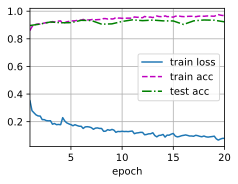

In [12]:
train_accuracy(net_resnet, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [13]:
net_resnet.cpu()
Y_pred_res = net_resnet(X_test)

np_Y_pred_res = Y_pred_res.argmax(axis=1).numpy()
np_Y_test_name = Y_test.argmax(axis=1).numpy()

In [14]:
cm_3c = confusion_matrix(np_Y_test_name, np_Y_pred_res)

In [15]:
def plot_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm / np.sum(cm, axis=1).reshape(-1, 1), range(3), range(3))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

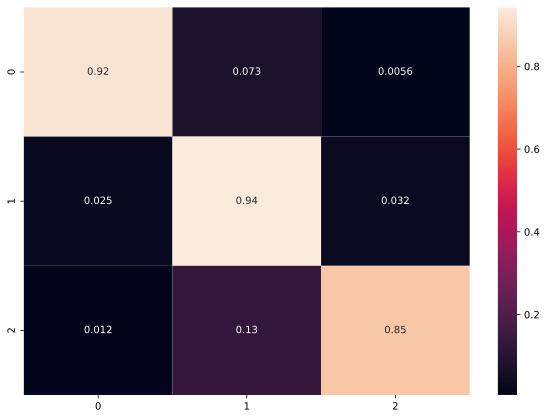

In [16]:
plot_confusion_matrix(cm_3c)

In [17]:
np_Y_train_num = np.argmax(np_Y_train, axis=1).reshape(np_Y_train.shape[0], 1)
np.unique(np_Y_train_num, return_counts=True)

(array([0, 1, 2], dtype=int64), array([4753, 6168, 1441], dtype=int64))

In [18]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy = {2: 4000})
np_X_train_smt, np_Y_train_smt = smote.fit_resample(np_X_train, np_Y_train_num)
np.unique(np_Y_train_smt, return_counts=True)

(array([0, 1, 2], dtype=int64), array([4753, 6168, 4000], dtype=int64))

In [19]:
np_X_train_smt = np_X_train_smt.reshape(np_X_train_smt.shape[0], 2, np_X_train_smt.shape[1] // 2)
np_Y_train_smt = pd.get_dummies(np_Y_train_smt).values
X_train = torch.tensor(np_X_train_smt, dtype=torch.float32)
Y_train = torch.tensor(np_Y_train_smt, dtype=torch.float32)

loss 0.032, train acc 0.988, test acc 0.917
1792.7 examples/sec on cuda:0


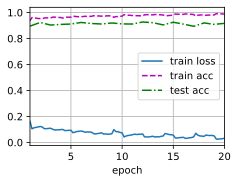

In [20]:
net_resnet_smt = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 3))

train_accuracy(net_resnet_smt, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [21]:
net_resnet_smt.cpu()
Y_pred_res_smt = net_resnet_smt(X_test)

np_Y_pred_res_smt = Y_pred_res_smt.argmax(axis=1).numpy()

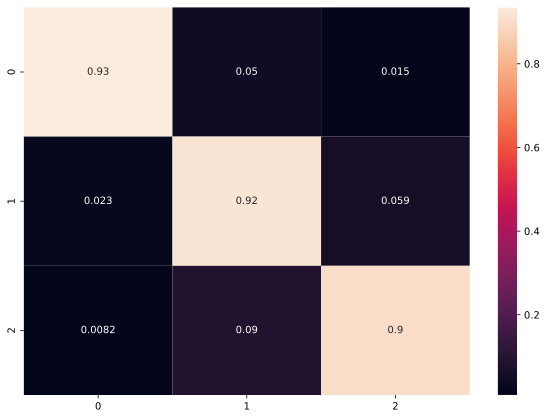

In [22]:
cm_smt = confusion_matrix(np_Y_test_name, np_Y_pred_res_smt)
plot_confusion_matrix(cm_smt)

In [23]:
smote2 = SMOTE(sampling_strategy = 'not majority')
np_X_train_smt_2, np_Y_train_smt_2 = smote2.fit_resample(np_X_train, np_Y_train_num)
np.unique(np_Y_train_smt_2, return_counts=True)

(array([0, 1, 2], dtype=int64), array([6168, 6168, 6168], dtype=int64))

In [28]:
np_X_train_smt_2[15000]

array([[[ 1.89565700e-02,  1.82385700e-02,  1.76854200e-02, ...,
          5.77795900e-03,  4.14780400e-03,  3.84741600e-03],
        [ 0.00000000e+00,  5.05283778e-04,  1.11578914e-03, ...,
          2.28403329e+00,  3.41431390e-01,  3.09738896e-01]],

       [[-8.71593300e-04,  1.57783400e-04, -2.31363800e-04, ...,
          8.31948800e-03,  1.68932500e-03, -6.60189200e-03],
        [ 0.00000000e+00,  2.78121471e-04,  7.85720387e-04, ...,
          8.03341006e-01,  2.40430453e-01,  1.70488449e-01]],

       [[ 1.18547100e-02,  1.62079000e-02,  1.34519000e-02, ...,
          2.58136000e-02,  1.01757100e-02,  3.31868400e-03],
        [ 0.00000000e+00,  2.02021818e-04,  1.43514026e-03, ...,
          1.22987754e+00,  4.39152964e-01,  1.23839357e-01]],

       ...,

       [[ 9.52915177e-03, -1.30420904e-03, -4.70066584e-04, ...,
          1.07819854e-02,  1.25287113e-02,  9.26795384e-03],
        [ 0.00000000e+00,  6.34894468e-05,  4.66737740e-04, ...,
          5.45254721e-01,  1.42821

In [24]:
np_X_train_smt_2 = np_X_train_smt_2.reshape(np_X_train_smt_2.shape[0], 2, np_X_train_smt_2.shape[1] // 2)
np_Y_train_smt_2 = pd.get_dummies(np_Y_train_smt_2).values
X_train = torch.tensor(np_X_train_smt_2, dtype=torch.float32)
Y_train = torch.tensor(np_Y_train_smt_2, dtype=torch.float32)

loss 0.022, train acc 0.992, test acc 0.915
1575.9 examples/sec on cuda:0


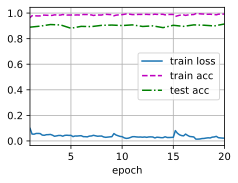

In [25]:
net_resnet_smt_2 = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 3))

train_accuracy(net_resnet_smt_2, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [26]:
net_resnet_smt_2.cpu()
Y_pred_res_smt_2 = net_resnet_smt_2(X_test)

np_Y_pred_res_smt_2 = Y_pred_res_smt_2.argmax(axis=1).numpy()

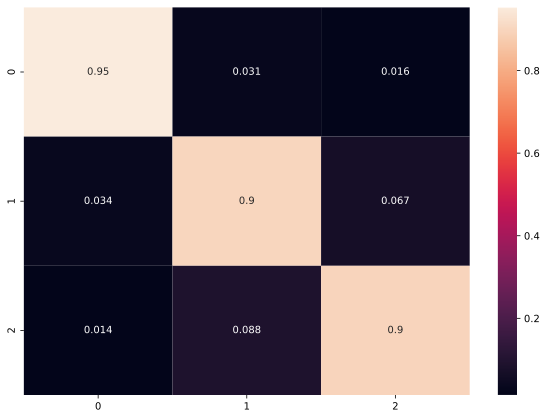

In [27]:
cm_smt_2 = confusion_matrix(np_Y_test_name, np_Y_pred_res_smt_2)
plot_confusion_matrix(cm_smt_2)